In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import hdf5plugin
import h5py as h5
import dask.array as darray
import dask
from scipy.signal import convolve2d
from PIL import Image

In [2]:
def ttc_to_g2(ttc, time=None):
    """Calculate g2 function from TTC

    Args:
        cor (np.ndarray): sqaure correlation matrix (TTC)
        time (np.ndarray, optional): 1D vector of lag times. Defaults to None.
            If None, np.arange will be used for evenly spaced time bins.
    """

    ntimes = ttc.shape[0]
    if time is None:
        time = np.arange(ntimes) + 1

    # initialize output array
    tau = np.ones(ntimes)
    g2 = np.ones(ntimes)
    g2_err = np.ones(ntimes)
    tau = time
    for i in range(1, ntimes):
        dia = np.diag(ttc, k=i)
        ind = np.where(np.isfinite(dia))
        if len(dia[ind]):
            g2[i-1] = np.mean(dia[ind])
            g2_err[i-1] = np.std(dia[ind])
    g2_err *= np.sqrt(1.0 / (ntimes))
    return tau, g2[:-1], g2_err[:-1]

In [55]:
with h5.File('ttc.hdf5') as cpp_file:
    cpp_img = cpp_file['waxs/data'][()]
    cpp_roi = cpp_file['waxs/roi_data'][()]

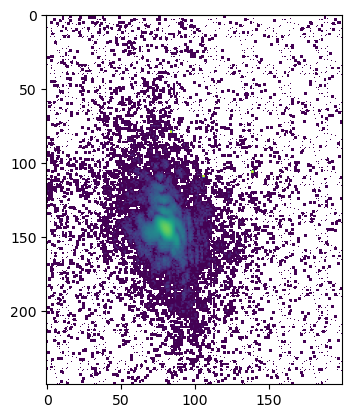

In [56]:
plt.imshow(cpp_roi.T, norm=LogNorm())

In [18]:
with h5.File('data/scan_000181_eiger500k.hdf5') as original_file:
    original_image = original_file['/entry/instrument/Eiger/data'][()]
original_image = original_image.mean(0)

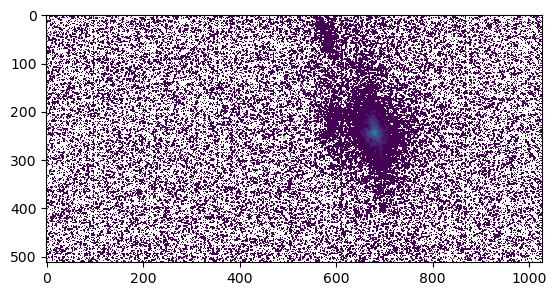

In [19]:
plt.imshow(original_image, norm=LogNorm())

In [57]:
f = h5.File('ttc.hdf5', 'r')
ttc_dset = f['/ttc/data']
ttc = darray.from_array(ttc_dset)
time = f['/ttc/time_axis'][()][0]

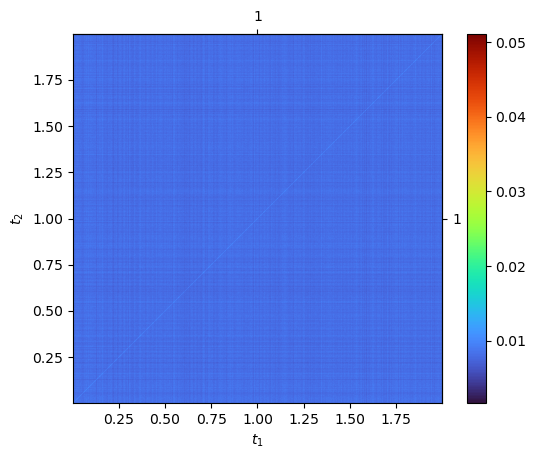

In [58]:
ttc_submat = ttc_dset[()]
fig, ax = plt.subplots()
ttc_plot = ax.imshow(
    ttc_submat,
    # norm=LogNorm(),
    origin='lower',
    cmap='turbo',
    extent=[time.min(), time.max(), time.min(), time.max()]
)
ax_x = ax.secondary_yaxis('right')
ax_x.set_yticks(np.arange(0,ttc_submat.shape[0]))
ax_y = ax.secondary_xaxis('top')
ax_y.set_xticks(np.arange(0,ttc_submat.shape[0]))
ax.set_xlabel('$t_1$')
ax.set_ylabel('$t_2$')
fig.colorbar(ttc_plot)
plt.show()

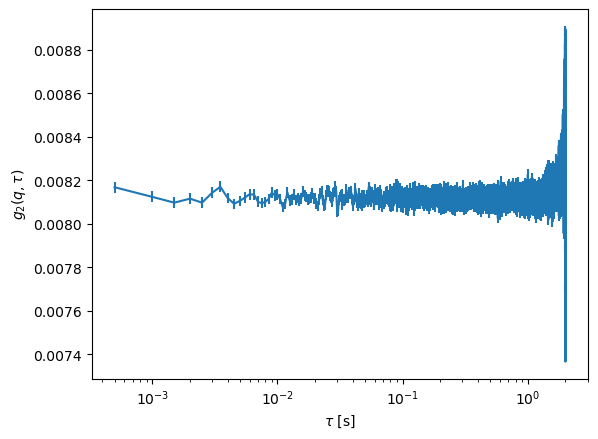

In [59]:
_, g2, g2_err = ttc_to_g2(ttc_submat, 500)
plt.errorbar(time, g2, yerr=g2_err)
plt.xscale('log')
# plt.xlim(time[0]-0.01,0.1)
plt.ylabel(r'$g_2(q, \tau)$')
plt.xlabel(r'$\tau$ [s]')
plt.show()

In [37]:
f.close()